### Standard LSTM Model

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
import shap
import lime.lime_tabular
from IPython.display import display, HTML

/Users/amalshar/miniforge3/envs/mlenv64/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tf.compat.v1.enable_eager_execution()

In [3]:
# Load data
df = pd.read_csv('/Users/amalshar/Desktop/USD/Fall 2025/Data Analysis/Final Project/daily_2025_cleaned_data.csv')

In [4]:
# Define features and target
FEATURES = ['CO', 'SO2', 'NO2', 'O3', 'PM25',
            'BarometricPressure', 'Temperature', 'WindResultant']
TARGET = 'DailyAQI'

X = df[FEATURES].values
y = df[TARGET].values.reshape(-1, 1)

In [5]:
# Scaling
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [6]:
# Create sequences (7-day lookback)
def create_sequences(X, y, time_steps=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 7
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)
print("X_seq shape", X_seq.shape)

X_seq shape (94124, 7, 8)


In [7]:
# Train / Test split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

Train Shape: (75299, 7, 8)
Test Shape: (18825, 7, 8)


In [8]:
# Build LSTM model
model = Sequential([
    Input(shape=(time_steps, len(FEATURES))),
    LSTM(50, activation='relu', return_sequences=True),
    BatchNormalization(),
    LSTM(50, activation='relu'),
    BatchNormalization(),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 50)          │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 50)          │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,451 (126.76 KB)

 Trainable params: 32,251 (125.98 KB)

 Non-trainable params: 200 (800.00 B)

In [9]:
# Train with Early Stopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=1000, 
                    batch_size=32, 
                    validation_split=0.2, 
                    callbacks=[es], 
                    verbose=1)

Epoch 1/1000
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.0097 - val_loss: 0.0011
Epoch 2/1000
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 3/1000
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 5.4400e-04 - val_loss: 0.0022
Epoch 4/1000
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 4.4950e-04 - val_loss: 4.4574e-04
Epoch 5/1000
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.9845e-04 - val_loss: 7.1055e-04
Epoch 6/1000
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.8959e-04 - val_loss: 0.0012
Epoch 7/1000
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.8439e-04 - val_loss: 2.9963e-04
Epoch 8/1000
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.5994e-04 - val_loss: 5.3255e-04
Epoch 9/1000
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.5310e-04 - val_loss: 0.0021
Epoch 10/1000
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 3.4250e-04 - val_loss: 4.1165e-04
Epoch 11/1000
1883/1883 ━━━━━━━━━━━━━━━━━━━━ 6s

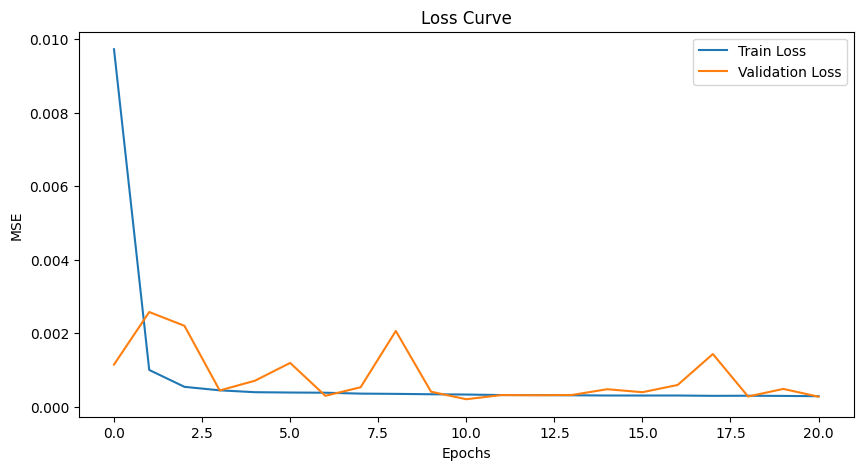

In [10]:
# Loss plot
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [11]:
# Predictions
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test)

589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [12]:
# Evaluation metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared (R²): {r2:.3f}")

Mean Squared Error (MSE): 3169.103
Root Mean Squared Error (RMSE): 56.295
Mean Absolute Error (MAE): 22.787
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R²): 0.086


/var/folders/rx/gyp8p3vs42zfzk_hwhrnpcmw0000gn/T/ipykernel_31205/1779788710.py:5: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


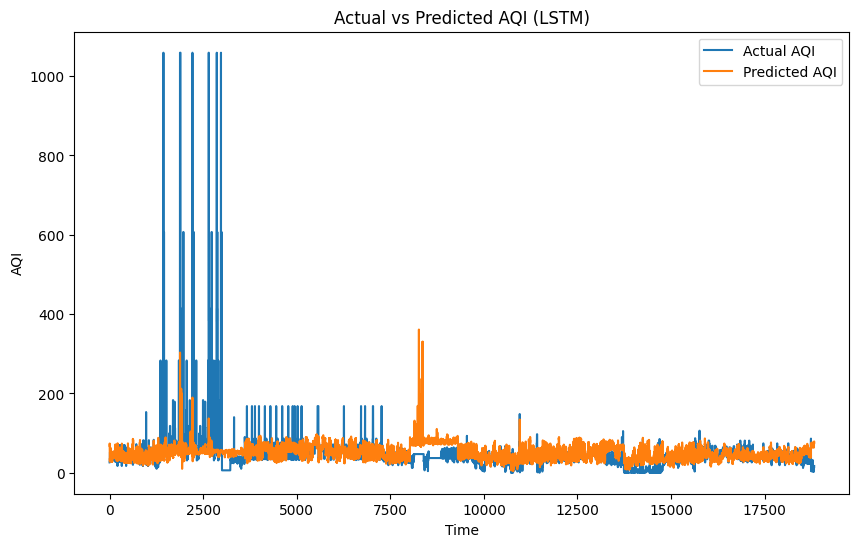

In [13]:
# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Actual AQI')
plt.plot(y_pred, label='Predicted AQI')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.title('Actual vs Predicted AQI (LSTM)')
plt.legend()
plt.show()

In [14]:
# Approximate Feature Importance (Permutation-based)
from sklearn.inspection import permutation_importance

def permutation_importance_lstm(model, X_test, y_true, metric=r2_score):
    baseline_preds = model.predict(X_test)
    baseline_score = metric(y_true, scaler_y.inverse_transform(baseline_preds))
    
    importances = {}
    
    for i, feature in enumerate(FEATURES):
        X_test_perm = X_test.copy()
        
        # Shuffle values of feature i across all timesteps
        for t in range(time_steps):
            np.random.shuffle(X_test_perm[:, :, i])
        
        # Predict and get score
        preds_perm = model.predict(X_test_perm)
        score_perm = metric(y_true, scaler_y.inverse_transform(preds_perm))
        
        # Importance is the decrease in performance
        importances[feature] = baseline_score - score_perm
    
    return importances

In [15]:
# Run feature importance
feature_importances = permutation_importance_lstm(model, X_test, y_true)

# Sort and print feature importance
sorted_importance = pd.DataFrame(feature_importances.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)
print("\nPermutation Feature Importance (LSTM):")
print(sorted_importance)

589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 866us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 859us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
589/589 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  

Permutation Feature Importance (LSTM):
              Feature  Importance
4                PM25    0.168525
6         Temperature    0.015191
7       WindResultant    0.008214
2                 NO2    0.002712
3                  O3    0.002049
0                  CO   -0.003108
1                 SO2   -0.020596
5  BarometricPressure   -0.040846


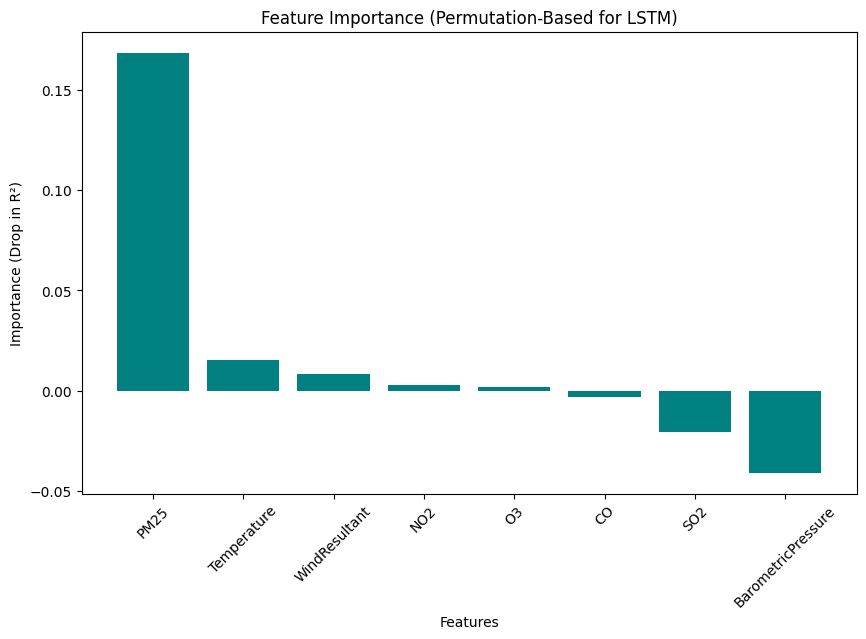

In [16]:
# Plot importance
plt.figure(figsize=(10, 6))
plt.bar(sorted_importance['Feature'], sorted_importance['Importance'], color='teal')
plt.xlabel('Features')
plt.ylabel('Importance (Drop in R²)')
plt.title('Feature Importance (Permutation-Based for LSTM)')
plt.xticks(rotation=45)
plt.show()

In [17]:
# Flatten training and test sequences
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
feature_names = [f"{feat}_t-{i}" for i in range(time_steps) for feat in FEATURES]

def predict_wrapper(flat_input):
    reshaped = flat_input.reshape(-1, time_steps, len(FEATURES))
    return model.predict(reshaped).flatten()

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_flat,
    feature_names=feature_names,
    mode='regression'
)

i = 0
exp = lime_explainer.explain_instance(
    data_row=X_test_flat[i],
    predict_fn=predict_wrapper,
    num_features=10
)

# Display LIME results
try:
    exp.show_in_notebook(show_table=True)
except:
    display(HTML(exp.as_html()))

# Save to HTML
with open("exp6_lime_explanation.html", "w") as f:
    f.write(exp.as_html())


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step


 10%|█         | 1/10 [00:00<00:07,  1.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 20%|██        | 2/10 [00:01<00:07,  1.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 30%|███       | 3/10 [00:02<00:06,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 40%|████      | 4/10 [00:03<00:05,  1.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 50%|█████     | 5/10 [00:04<00:04,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step


 60%|██████    | 6/10 [00:05<00:03,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step


 70%|███████   | 7/10 [00:06<00:02,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


 80%|████████  | 8/10 [00:06<00:01,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


 90%|█████████ | 9/10 [00:07<00:00,  1.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


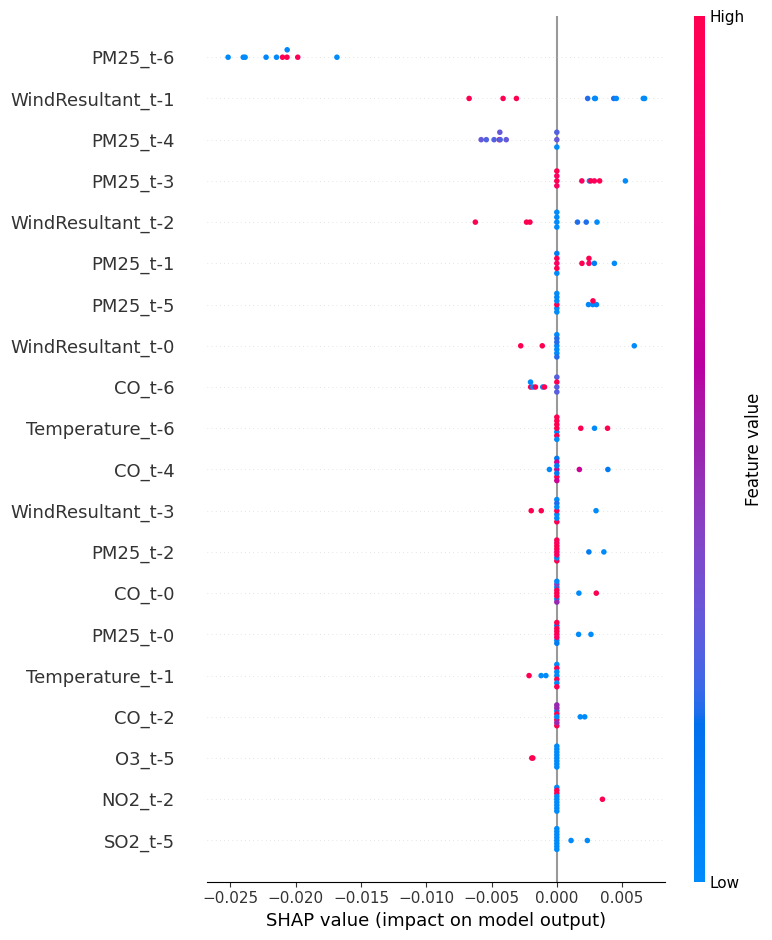

In [18]:
background = X_train_flat[:100]
test_samples = X_test_flat[:10]

shap_explainer = shap.KernelExplainer(predict_wrapper, background)
shap_values = shap_explainer.shap_values(test_samples, nsamples=200)

# SHAP summary plot
shap.summary_plot(shap_values, test_samples, feature_names=feature_names)